<a href="https://colab.research.google.com/github/angelsb008/Default_credit_card_exercise/blob/main/Test_Default_Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip3 install -U ucimlrepo

In [ ]:
!pip3 install -U XGBRegressor

In [94]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error,mean_absolute_error, roc_curve, auc, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Define catalogues

In [3]:
sex_map = {1: 'Male', 2: 'Female'}
payment_map = {0: 'Default payment: No', 1: 'Default payment: Yes'}
education_map = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marital_map = {1: 'married', 2: 'single', 3: 'others'}

# Methods

In [67]:
def graph_histogram_EDA(df_input, field, kde_bool = True, bin_number = 30):
  plt.figure(figsize=(8,5))
  sns.histplot(df_input[field], kde = kde_bool, bins=bin_number)
  plt.ticklabel_format(style='plain', axis='x')
  plt.title(f"Distribution of {field}")
  plt.grid()
  plt.show()

In [71]:
def pie_chart_two_fields(df_input, field_1, field_2, map_1, map_2):
    counts = df_input.groupby([field_1, field_2]).size().reset_index(name='count')
    counts['label'] = counts.apply(lambda row: f"{map_1[row[field_1]]} - {map_2[row[field_2]]}", axis=1)
    sizes = counts['count']
    labels = counts['label']
    cmap = plt.get_cmap('Pastel1')
    colors = cmap.colors[:len(sizes)]
    def func_num(pct):
        absolute = int(round(pct/100.*sum(sizes)))
        return str(absolute)
    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts  = ax.pie(sizes, labels=labels, colors=colors, autopct=func_num,
                                      wedgeprops=dict(width=1, edgecolor='w')
    )
    plt.title(f"Number of {field_2} per {field_1}")
    plt.show()

# Modify from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

# Import 'Default of credit card clients' dataset

Yeh, I. (2009). Default of Credit Card Clients [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C55S3H.

In [13]:
# Code copied from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

default_of_credit_card_clients = fetch_ucirepo(id=350)
X = default_of_credit_card_clients.data.original # change .features to .original
y = default_of_credit_card_clients.data.targets

# Dataset cleaning / preprocessing data

## First impressions

In [14]:
# Original df
X

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [15]:
# For to understand each field
print(default_of_credit_card_clients.metadata['additional_info']['variable_info'])

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and

## Rename fields

In [19]:
default_of_credit_card_clients.variables["description"]

,description
0,None
1,LIMIT_BAL
2,SEX
3,EDUCATION
4,MARRIAGE
5,AGE
6,PAY_0
7,PAY_2
8,PAY_3
9,PAY_4


In [20]:
## Get actual field names
fields_list = X.columns.to_list()
## Get their respective description for each field
description_fields_list = default_of_credit_card_clients.variables["description"].tolist()
## Particular renames
description_fields_list[0] = "ID"
description_fields_list[6] = "PAY_1"
description_fields_list[-1] = "DEF_PAY_NEXT_MONTH"
## Rename
X.columns = description_fields_list
X

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Verify if exists different values that not exists into their respective catalogue per each column. If it's the case, standarding.

### For SEX field

In [21]:
## For SEX
X["SEX"].unique()

array([2, 1])

### FOR EDUCATION field

In [22]:
X["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [23]:
X.loc[~X['EDUCATION'].isin([1,2,3,4]), 'EDUCATION'] = 4
X["EDUCATION"].unique()

array([2, 1, 3, 4])

### For MARRIAGE field

In [24]:
X["MARRIAGE"].unique()

array([1, 2, 3, 0])

In [25]:
X.loc[~X['MARRIAGE'].isin([1,2,3]), 'MARRIAGE'] = 3
X["MARRIAGE"].unique()

array([1, 2, 3])

### For PAY_X fields

"X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. **The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.**"

**It doesn't makes much sense that exists some repayment status with values: '0', or, '-2'**

**0 = Pending payment for the current month?**

**-2 = Pay duly twice (error system)? / Advance pay? / Credit Balance?**

In [26]:
for i in range(1, 7):
  print(f"Values in 'PAY_{i}' column: ", X[f"PAY_{i}"].unique())

Values in 'PAY_1' column:  [ 2 -1  0 -2  1  3  4  8  7  5  6]
Values in 'PAY_2' column:  [ 2  0 -1 -2  3  5  7  4  1  6  8]
Values in 'PAY_3' column:  [-1  0  2 -2  3  4  6  7  1  5  8]
Values in 'PAY_4' column:  [-1  0 -2  2  3  4  5  7  6  1  8]
Values in 'PAY_5' column:  [-2  0 -1  2  3  5  4  7  8  6]
Values in 'PAY_6' column:  [-2  2  0 -1  3  6  4  7  8  5]


In [27]:
X[X["PAY_1"]==0].iloc[5].T

,8
ID,9
LIMIT_BAL,140000
SEX,2
EDUCATION,3
MARRIAGE,1
AGE,28
PAY_1,0
PAY_2,0
PAY_3,2
PAY_4,0


### Verify doesn't exists duplicate and null values

In [28]:
# Delete possible rows duplicates in the dataset
X = X.drop_duplicates()
X

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [29]:
# Check if exists any null value
X.isnull().values.any()

np.False_

In [30]:
# Delete fields without important information
X.drop(["ID"], axis=1, inplace=True)
X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# EDA (Exploratory Data Analysis)

## For generate the measures of central tendency


In [31]:
# For generate the measures of central tendency
X.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.842267,0.744494,1.0,1.00,2.0,2.00,4.0
MARRIAGE,30000.0,1.557267,0.521405,1.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


## Generate graphs with EDA information

In [58]:
X["LIMIT_BAL"].mode()

,LIMIT_BAL
0,50000


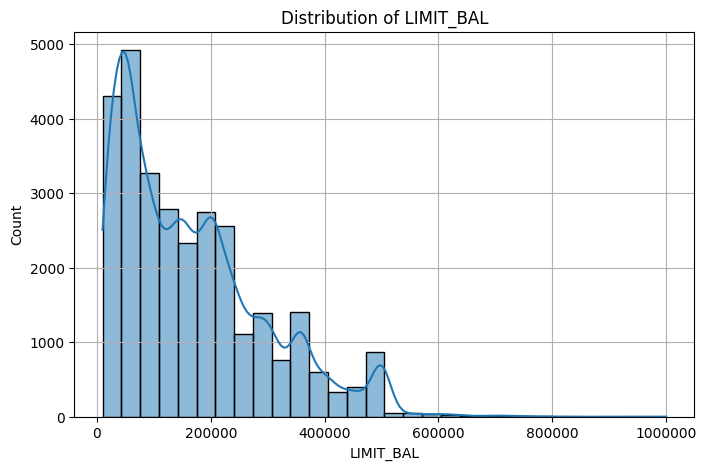

In [68]:
graph_histogram_EDA(X, "LIMIT_BAL")

In [70]:
X["AGE"].mode()

,AGE
0,29


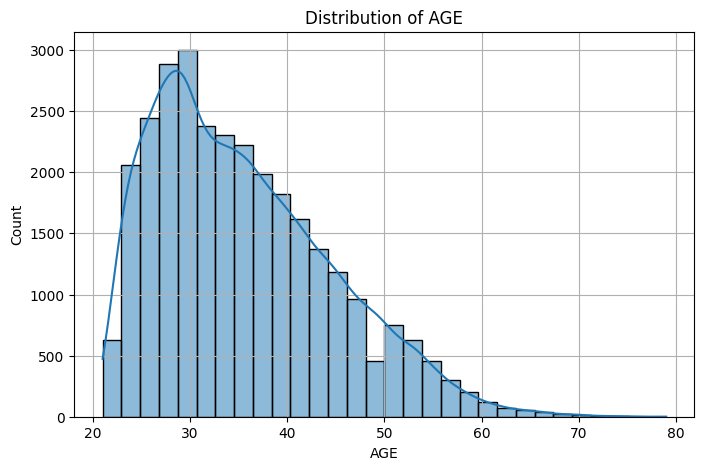

In [69]:
graph_histogram_EDA(X, "AGE")

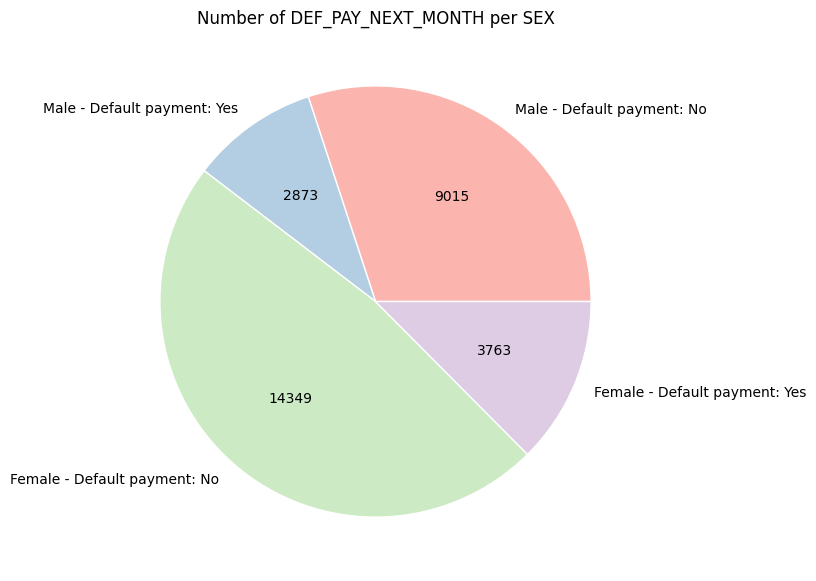

In [72]:
pie_chart_two_fields(X, "SEX", "DEF_PAY_NEXT_MONTH", sex_map, payment_map)

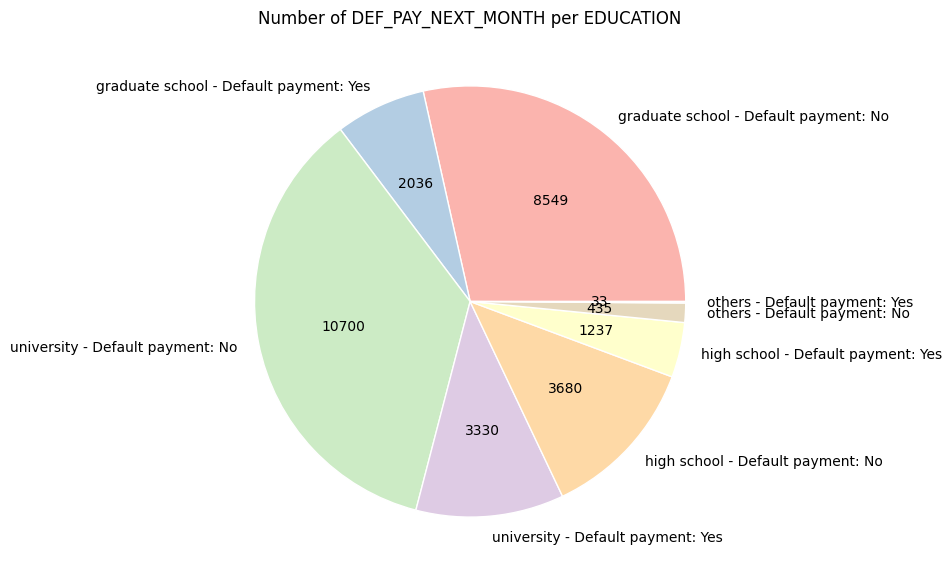

In [73]:
pie_chart_two_fields(X, "EDUCATION", "DEF_PAY_NEXT_MONTH", education_map, payment_map)

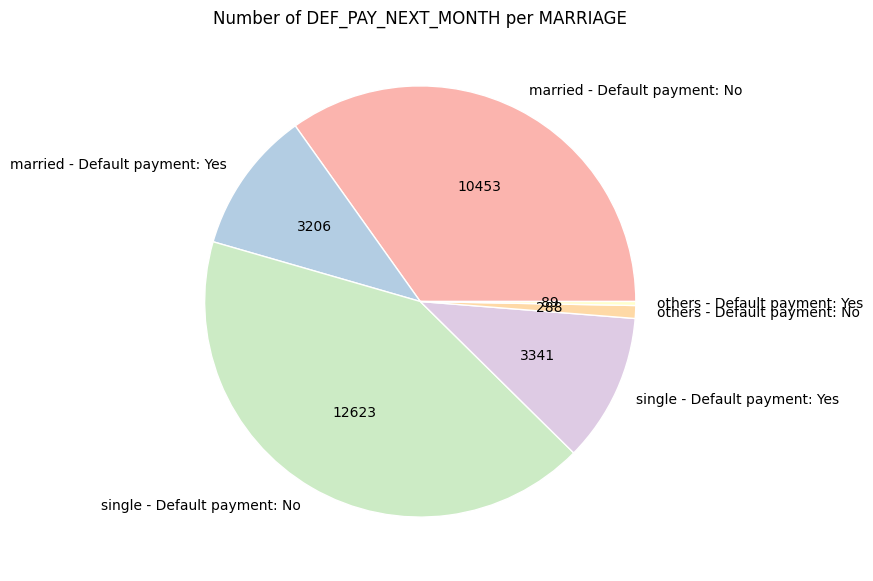

In [74]:
pie_chart_two_fields(X, "MARRIAGE", "DEF_PAY_NEXT_MONTH", marital_map, payment_map)

# Predictions

## For ***default.payment.next.month*** variable (categorical variable)

### Data preparation

In [37]:
## Separation of feature columns and solution columns of the data frame
X_default_df = X.drop(["DEF_PAY_NEXT_MONTH"], axis=1)
Y_default_df = X["DEF_PAY_NEXT_MONTH"]

## Getting of training and test sets | Train: 20% - Test: 80%
X_default_TRAIN_df, X_default_TEST_df, \
Y_default_TRAIN_df, Y_default_TEST_df = train_test_split(X_default_df, Y_default_df, test_size=0.2, random_state=42)

## StandardScaler for train set -> Z-score: Transform all the data to the "same scale"
scaler = StandardScaler()
X_default_TRAIN_scaled = scaler.fit_transform(X_default_TRAIN_df) # -> fit transform, for avoid data leaking
X_default_TEST_scaled  = scaler.transform(X_default_TEST_df) # -> only transform, it's the test set

## Return data to a DF
X_default_TRAIN_scaled_df = pd.DataFrame(X_default_TRAIN_scaled, columns=X_default_TRAIN_df.columns, index=X_default_TRAIN_df.index)
X_default_TEST_scaled_df  = pd.DataFrame(X_default_TEST_scaled,  columns=X_default_TEST_df.columns,  index=X_default_TEST_df.index)

### Logistic Regressor

In [38]:
# Train the Logisctic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_default_TRAIN_scaled_df, Y_default_TRAIN_df)

LogisticRegression(max_iter=1000)

In [39]:
# Predict data
y_pred = model.predict(X_default_TEST_scaled_df)

In [40]:
np.unique(y_pred)

array([0, 1])

In [54]:
print(classification_report(y_pred, Y_default_TEST_df))
print('\nAccuracy Score for model1: ', accuracy_score(y_pred,Y_default_TEST_df))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      5555
           1       0.24      0.69      0.35       445

    accuracy                           0.81      6000
   macro avg       0.60      0.76      0.62      6000
weighted avg       0.92      0.81      0.85      6000


Accuracy Score for model1:  0.81


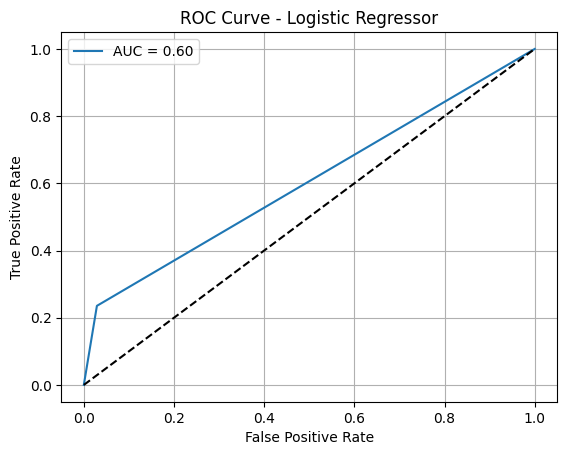

In [87]:
# Output the ROC AUC Score
auc = roc_auc_score(Y_default_TEST_df, y_pred)
fpr, tpr, thresholds = roc_curve(Y_default_TEST_df, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regressor")
plt.legend()
plt.grid()
plt.show()

### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
# Train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_default_TRAIN_scaled_df, Y_default_TRAIN_df)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [77]:
# Predict Data
rf_pred = rf_model.predict(X_default_TEST_scaled_df)

In [78]:
print(classification_report(Y_default_TEST_df, rf_pred))
print('Accuracy:', accuracy_score(Y_default_TEST_df, rf_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.64      0.36      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Accuracy: 0.8155


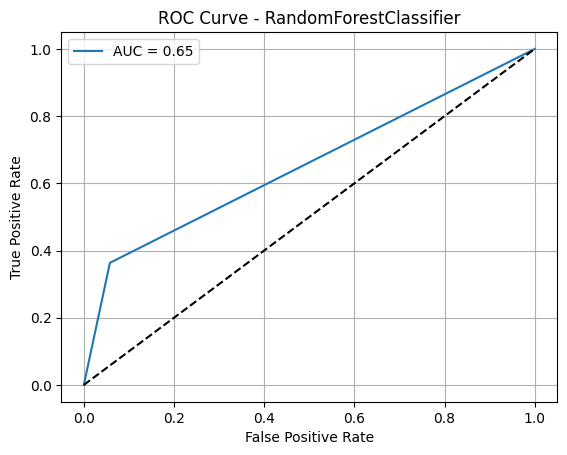

In [89]:
# Output the ROC AUC Score
auc = roc_auc_score(Y_default_TEST_df, rf_pred)
fpr, tpr, thresholds = roc_curve(Y_default_TEST_df, rf_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RandomForestClassifier")
plt.legend()
plt.grid()
plt.show()

## For ***PAY_AMT4*** variable (continuos variable)

### Data preparation

In [92]:
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
            'PAY_5', 'PAY_6',
             'BILL_AMT5', 'BILL_AMT6',
             'PAY_AMT5', 'PAY_AMT6']

In [93]:
## Separation of feature columns and solution columns of the data frame
X_PMT4_df = X[features]
Y_PMT4_df = X["PAY_AMT4"]

## Getting of training and test sets | Train: 20% - Test: 80%
X_PMT4_TRAIN_df, X_PMT4_TEST_df, \
Y_PMT4_TRAIN_df, Y_PMT4_TEST_df = train_test_split(X_PMT4_df, Y_PMT4_df, test_size=0.2, random_state=42)

## StandardScaler for train set -> Z-score: Transform all the data to the "same scale"
scaler = StandardScaler()
X_PMT4_TRAIN_scaled = scaler.fit_transform(X_PMT4_TRAIN_df) # -> fit transform, for avoid data leaking
X_PMT4_TEST_scaled  = scaler.transform(X_PMT4_TEST_df) # -> only transform, it's the test set

## Return data to a DF
X_PMT4_TRAIN_scaled_df = pd.DataFrame(X_PMT4_TRAIN_scaled, columns=X_PMT4_TRAIN_df.columns, index=X_PMT4_TRAIN_df.index)
X_PMT4_TEST_scaled_df  = pd.DataFrame(X_PMT4_TEST_scaled,  columns=X_PMT4_TEST_df.columns,  index=X_PMT4_TEST_df.index)

### RandomForestRegressor

In [95]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_PMT4_TRAIN_scaled_df, Y_PMT4_TRAIN_df)

# Predecir data
y_pred_rf = rf_model.predict(X_PMT4_TEST_scaled_df)

In [96]:
# Performance
rmse = np.sqrt(mean_squared_error(Y_PMT4_TEST_df, y_pred_rf))
r2_rf = r2_score(Y_PMT4_TEST_df, y_pred_rf)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R2 score: {r2_rf:.2f}")

Random Forest RMSE: 8273.67
Random Forest R2 score: 0.58


### XGBoost Regressor

In [98]:
# Train the model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
xgb_model.fit(X_PMT4_TRAIN_scaled_df, Y_PMT4_TRAIN_df)

# Predict Data
y_pred_xgb = xgb_model.predict(X_PMT4_TEST_scaled_df)

In [99]:
# Performance
rmse_xgb = np.sqrt(mean_squared_error(Y_PMT4_TEST_df, y_pred_xgb))
r2_xgb = r2_score(Y_PMT4_TEST_df, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R2 score: {r2_xgb:.2f}")

XGBoost RMSE: 8424.16
XGBoost R2 score: 0.57
